In [11]:
import xarray as xr
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import netCDF4 as nc
import foscat.Synthesis as synthe
import xarray as xr

In [12]:
# define the healpix resolution
nside = 128
nest = True

# Get data from copernicus marine services, and extract what we need in ds

In [13]:
L4=xr.open_zarr(
 "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-045/arco/SST_GLO_PHY_L4_NRT_010_043/cmems_obs-sst_glo_phy_nrt_l4_P1D-m_202303/geoChunked.zarr"
 )
L3S=xr.open_zarr("https://s3.waw3-1.cloudferro.com/mdl-arco-time-045/arco/SST_GLO_SST_L3S_NRT_OBSERVATIONS_010_010/IFREMER-GLOB-SST-L3-NRT-OBS_FULL_TIME_SERIE_202211/timeChunked.zarr"
)
    
ds=L4[['mask','sea_ice_fraction']]
ds['SST']=L3S['sea_surface_temperature']
ds['quality_level']=L3S['quality_level']
ds=ds.sel(time=slice('2024-06-02', '2024-06-07'))
#for k in range(6):
#    file_path = '2024-06-%02d'%(k+1)
#    print(file_path)
ds=ds.stack(id=('latitude', 'longitude'))
ds

<xarray.Dataset> Size: 818MB
Dimensions:           (time: 6, id: 5760000)
Coordinates:
  * time              (time) datetime64[ns] 48B 2024-06-02 ... 2024-06-07
  * id                (id) object 46MB MultiIndex
  * latitude          (id) float32 23MB -79.95 -79.95 -79.95 ... 79.95 79.95
  * longitude         (id) float32 23MB -179.9 -179.9 -179.8 ... 179.9 179.9
Data variables:
    mask              (time, id) int8 35MB dask.array<chunksize=(6, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, id) float64 276MB dask.array<chunksize=(6, 3600), meta=np.ndarray>
    SST               (time, id) float64 276MB dask.array<chunksize=(1, 460800), meta=np.ndarray>
    quality_level     (time, id) float32 138MB dask.array<chunksize=(1, 460800), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

# Get the SST DATA and convertit in HEALPix

In [14]:
ds=ds
th=(90.0-ds['latitude'])/180.0*np.pi
ph=2*np.pi-(ds['longitude'])/180.0*np.pi
cell_ids=hp.ang2pix(nside,th.data,ph.data,nest=nest)

In [4]:
data=np.ones([6,12*nside**2])*hp.UNSEEN
for k in range(6):
    file_path = 'data/202406%02d000000-IFR-L3S_GHRSST-SSTfnd-ODYSSEA-GLOB_010-v02.1-fv01.0.nc'%(k+1)
    
    # get the data from NetCDF
    dataset = nc.Dataset(file_path, 'r')
    lat=dataset['lat'][:]
    lon=dataset['lon'][:]
    sst=dataset['sea_surface_temperature'][0,:,:]
    q=dataset['quality_level'][0,:,:]
    dataset.close()

    # compute the coordinate
    hidx=hp.ang2pix(nside,
                    (90-np.repeat(lat,lon.shape[0]))/180.*np.pi,
                    270.0-np.tile(lon,lat.shape[0])/180.*np.pi,nest=True)

    hsst=np.bincount(hidx,weights=((q>3)*sst).flatten(),minlength=12*nside**2)
    wsst=np.bincount(hidx,weights=(q>3).flatten(),minlength=12*nside**2)
    data[k,wsst>0]=hsst[wsst>0]/wsst[wsst>0]-273.0
    data[k,bathy>=0]=0.0

<Figure size 640x480 with 0 Axes>

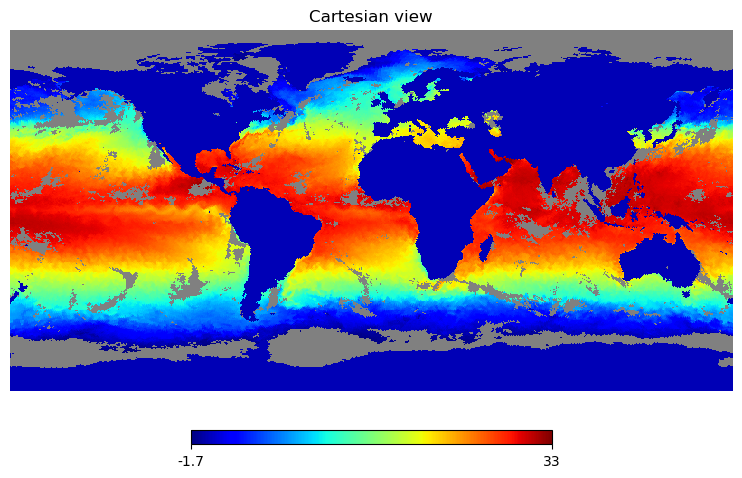

In [5]:
for i in range(1):
    plt.figure()
    hp.cartview(data[i],cmap='jet',nest=True)

2024-06-09 22:14:19.370640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


2024-06-09 22:14:23.524701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20972 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:61:00.0, compute capability: 8.9


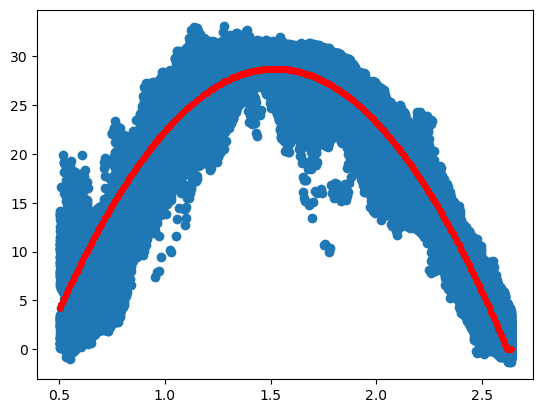

In [6]:
import foscat.scat_cov as sc

scat=sc.funct(silent=True, 
              JmaxDelta=4,        # The used Jmax is Jmax-JmaxDelta
              mask_norm=True,          # normalize mask
              mask_thres=0.7)


im=data[0].copy()

mask=np.expand_dims((data[0]!=hp.UNSEEN)*(bathy<0),0)

t,p=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
a=np.polyfit(t[mask[0]],im[mask[0]],2)

tmp=a[0]*t**2+a[1]*t+a[2]
tmp[tmp<0]=0.0
im[im==hp.UNSEEN]=tmp[im==hp.UNSEEN]
mask=np.expand_dims((data[0]!=hp.UNSEEN)*(bathy<0)*(t>0.5)*(t<np.pi-0.5),0)

plt.scatter(t[mask[0]],im[mask[0]])
plt.plot(t[mask[0]],tmp[mask[0]],'.',color='r')

ref=scat.eval(im,mask=mask)

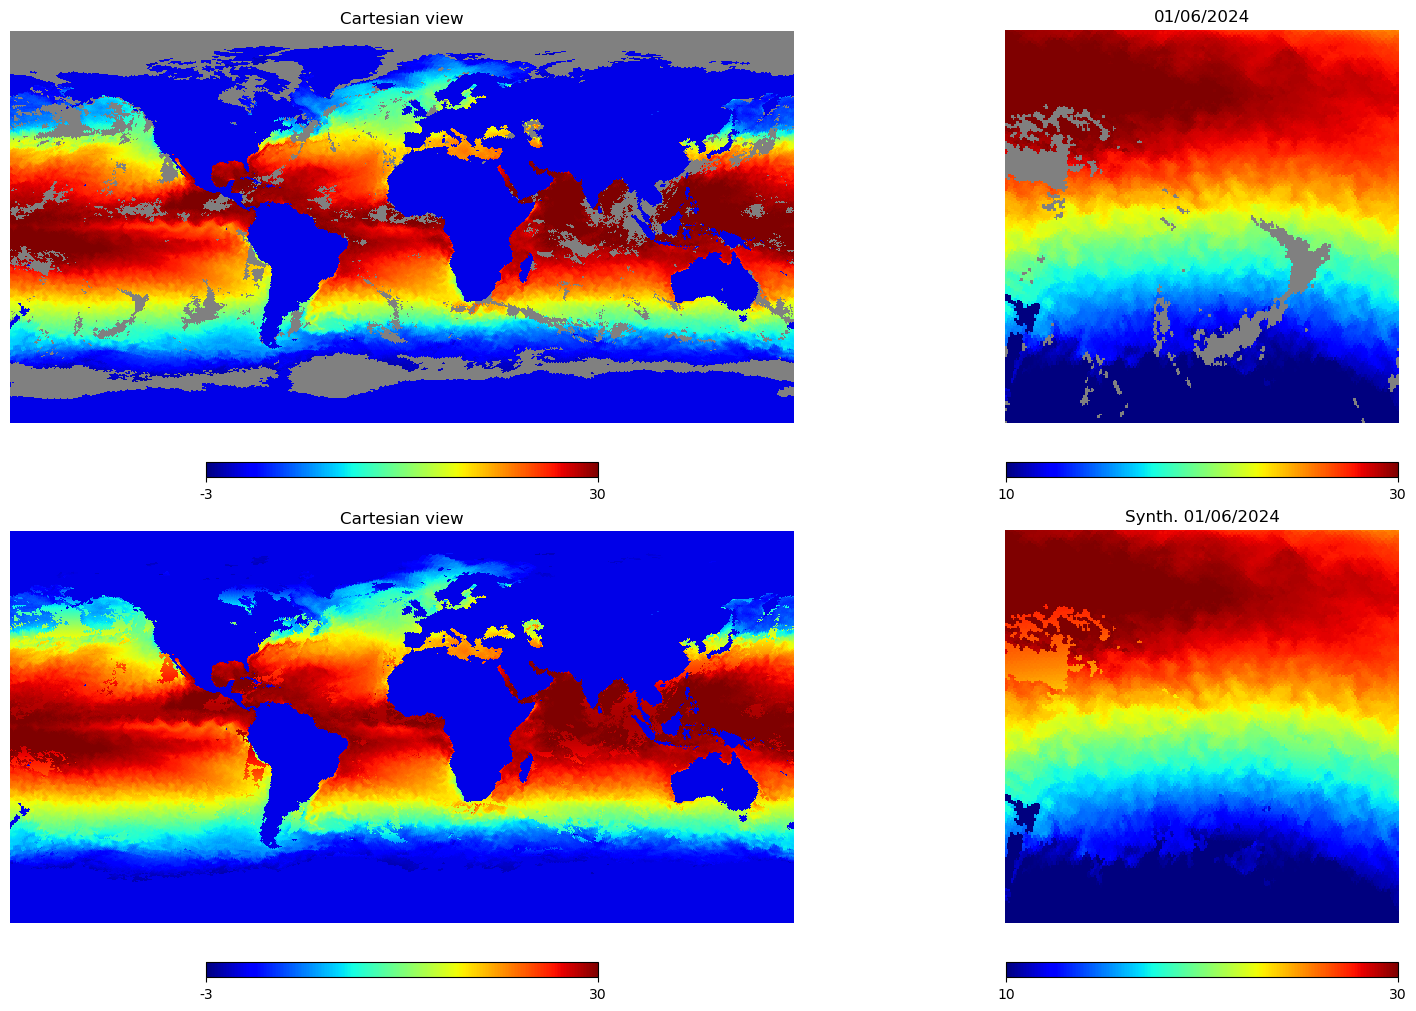

In [7]:
plt.figure(figsize=(16,10))
hp.cartview(data[0],nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,1))
hp.cartview(im,nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,3))
hp.gnomview(data[0],nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='01/06/2024',hold=False,sub=(2,2,2),xsize=256)
hp.gnomview(im,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='Synth. 01/06/2024',hold=False,sub=(2,2,4),xsize=256)

In [8]:
def The_loss_function(x,scat_operator,args,return_all=False):

    ref = args[0]
    mask = args[1]

    learn=scat_operator.eval(x,mask=mask)

    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/ref))

    return(loss)

In [9]:
#Start image is the input data
imap=im.copy()
imap

mask=np.expand_dims((bathy<0)*(t>0.5)*(t<np.pi-0.5),0)

loss=synthe.Loss(The_loss_function,scat,ref,
                 scat.backend.constant(scat.backend.bk_cast(mask)))

sy = synthe.Synthesis([loss])

#=================================================================================
# RUN ON SYNTHESIS
#=================================================================================

omap=sy.run(scat.backend.bk_cast(imap),
            EVAL_FREQUENCY=100,
            grd_mask=data[0]==hp.UNSEEN, # only the gradient of masked data is computed
            NUM_EPOCHS = 1000).numpy()

Total number of loss  1
 Run [PROC=0000] on GPU /device:GPU:0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Itt      0 L=     0.164 (     0.164 ) 31.338s 
Itt    100 L=  0.000881 (  0.000881 ) 12.908s 
Itt    200 L=  0.000869 (  0.000869 ) 12.305s 
Itt    300 L=  0.000863 (  0.000863 ) 12.241s 
Itt    4

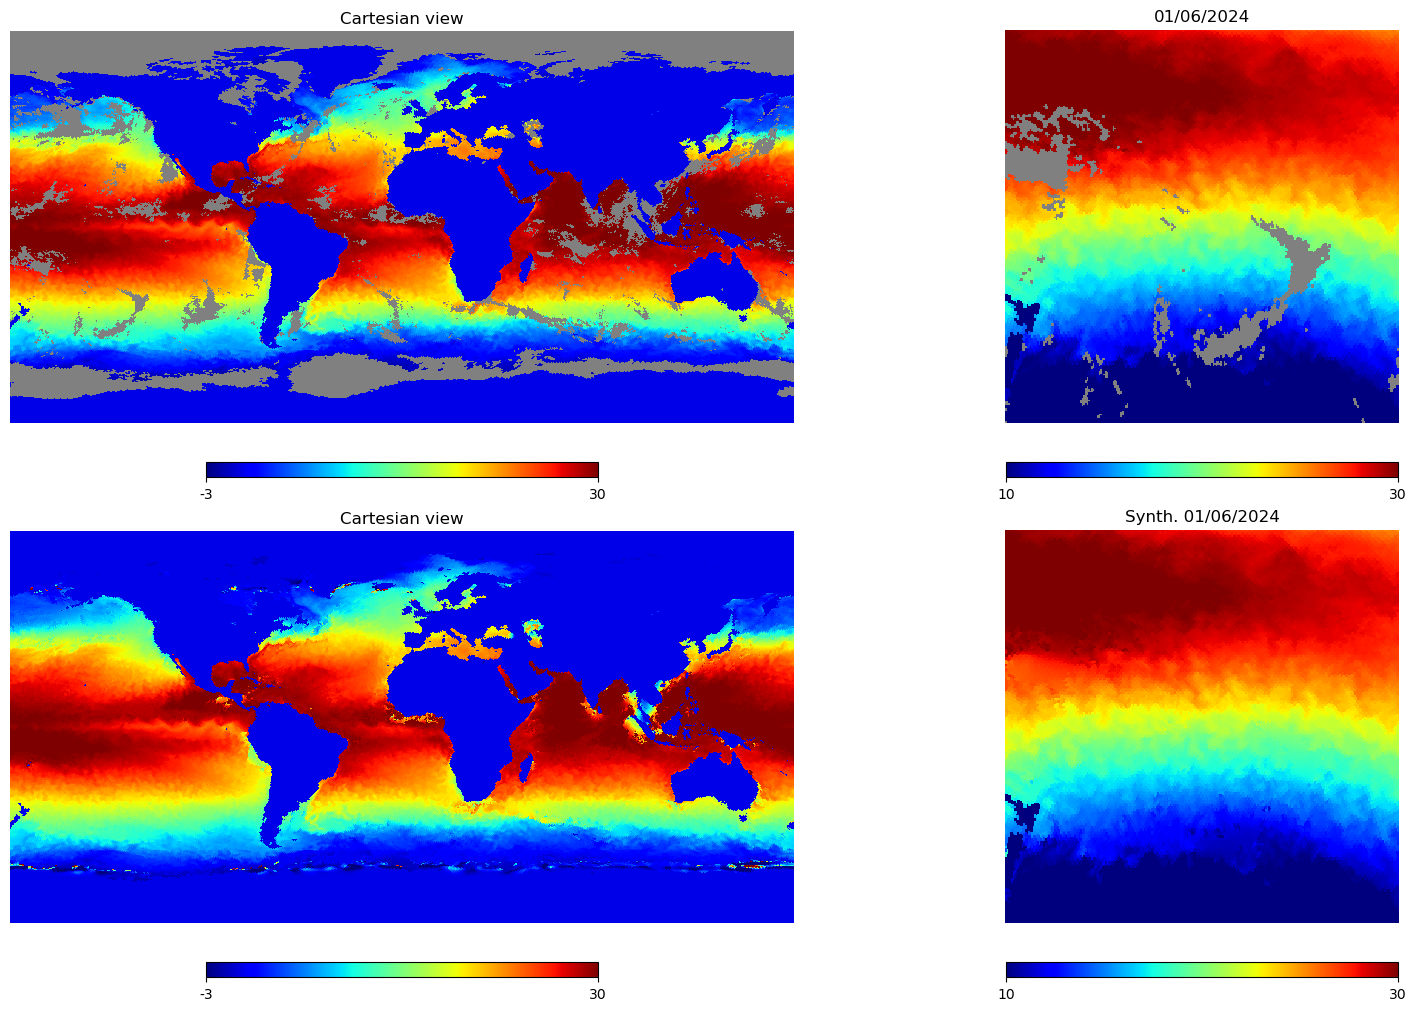

In [10]:
plt.figure(figsize=(16,10))
hp.cartview(data[0],nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,1))
hp.cartview(omap,nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,3))
hp.gnomview(data[0],nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='01/06/2024',hold=False,sub=(2,2,2),xsize=256)
hp.gnomview(omap,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='Synth. 01/06/2024',hold=False,sub=(2,2,4),xsize=256)